In [50]:
import pandas as pd
import numpy as np

In [51]:
#1.1计算每个国家因地震造成的总死亡人数，并打印前十名国家及其死亡人数
Sig_Eqs = pd.read_csv('earthquakes-2025-10-29_21-03-20_+0800.tsv', sep='\t')#读取TSV文件作为对象Sig_Eqs 
deaths_by_country = Sig_Eqs.groupby('Country')['Total Deaths'].sum().sort_values(ascending=False)
#Sig_Eqs按Country这一列的值分组，紧接着选中组内Total Deaths，考虑到要的是同一个国家所有地震总死亡对Total Deaths做一次求和操作，最后进行一次降序排列，此操作参考CSDN Pandas-排序函数sort_values()
top_10_countries = deaths_by_country.head(10)
print("Top 10 countries by total earthquake deaths:")
print(top_10_countries)

Top 10 countries by total earthquake deaths:
Country
CHINA         2106524.0
TURKEY        1008863.0
IRAN           761654.0
SYRIA          487726.0
ITALY          423280.0
HAITI          323782.0
JAPAN          319443.0
AZERBAIJAN     319251.0
INDONESIA      282838.0
ARMENIA        189000.0
Name: Total Deaths, dtype: float64


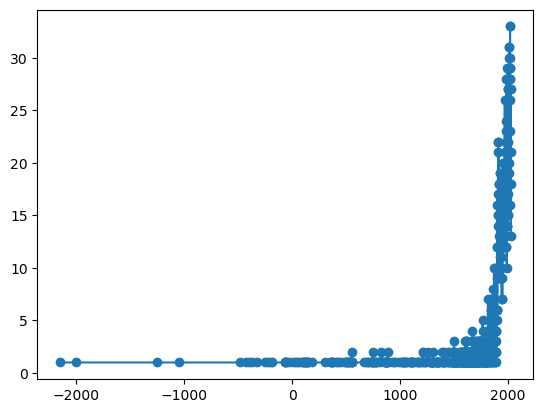

In [18]:
#1.2计算每年震级大于6.0的地震总数，并绘制时间序列图
year_eqs = Sig_Eqs[Sig_Eqs['Mag'] > 6.0].groupby('Year').size().reset_index(name='Count') 
#保留Sig_Eqs中震级Mag > 6.0的数据行，之后将这些数据行按年份（Year）分组，单独统计年份的分组计算它包含多少行在后续将统计的次数转化为Count列
plt.plot(year_eqs['Year'], year_eqs['Count'],marker='o') 
plt.show()

In [58]:
def CountEq_LargestEq(country): #定义一个函数，名字叫CountEq_LargestEq，输入是一个国家名字（比如 "CHINA"）
    sub = Sig_Eqs[Sig_Eqs['Country'] == country] #从整个地震数据表Sig_Eqs中，挑出所有“Country”这一列等于指定国家的行，存到 sub 这个小表格里
    total = len(sub)
    if total == 0:
        return total, None #如果这个国家一条地震记录都没有，就返回两个东西：0（地震次数）和 None（没有最大地震年份）
    if sub['Mag'].notna().any(): # 关键修复：检查是否有有效 Mag（震级），之前反复报错的原因就在于没有检测是否有空集，该部分在grok帮助下完成
        idx_max = sub['Mag'].idxmax()
        max_year = sub.loc[idx_max, 'Year']
        return total, int(max_year)
    else:
        return total, None  
        
countries = Sig_Eqs['Country'].dropna().unique() #从整个数据表里，取出“Country”这一列，去掉空的（NaN），再去重，得到所有出现过的国家名字，存到countries 列表里
results = [] #创建一个空列表，叫 results，用来装每个国家的统计结果

for country in countries: #开始一个循环：依次拿出countries列表里的每一个国家名字，赋值给country
    total, year = CountEq_LargestEq(country) #调用上面的函数，传入这个国家名字，得到两个返回值：地震次数和最大震级年份
    if total > 0:
        results.append({
            'Country': country,
            'Total_Earthquakes': total,
            'Largest_Eq_Year': year  #可能是None
        })
result_df = pd.DataFrame(results) #把results 这个列表（里面全是字典）转成一个pandas表格（DataFrame）
result_df = result_df.sort_values('Total_Earthquakes', ascending=False).reset_index(drop=True)
print(result_df.to_string(index=False)) 

                                     Country  Total_Earthquakes  Largest_Eq_Year
                                       CHINA                623           1668.0
                                       JAPAN                424           2011.0
                                   INDONESIA                421           2004.0
                                        IRAN                388            856.0
                                      TURKEY                358           1939.0
                                       ITALY                333           1915.0
                                      GREECE                289            365.0
                                         USA                280           1964.0
                                 PHILIPPINES                230           1897.0
                                      MEXICO                214           1787.0
                                       CHILE                200           1960.0
                            

In [7]:
#2.Wind speed in Shenzhen from 2010 to 2020
#本章节的数学原理均是在Grok的帮助下完成
#由于风力csv文件过大，无法上传，所以可以导致代码运行失败
import pandas as pd
import numpy as np 

In [8]:
df = pd.read_csv('2281305.csv', low_memory=False) #读取CSV文件（文件必须在当前目录），low_memory=False是因为列太多，pandas会警告，在Grok帮助下添加
# 从 'WND' 列提取风速（POS 66-69: 速度×10，9999=缺失）
#    WND 格式示例: "040,1,N,0020,1" 
#    风速在第4个字段（从0开始数：方向,质量,类型,速度×10,质量）
def get_wind_speed(wnd):
    # 如果是空值，直接返回 NaN
    if pd.isna(wnd):
        return np.nan
    # 按逗号分割
    parts = str(wnd).split(',')
    # 必须至少有4个部分
    if len(parts) < 4:
        return np.nan
    # 取出第4个字段（速度×10）
    speed_str = parts[3].strip()
    # 如果是 9999，表示缺失
    if speed_str == '9999':
        return np.nan
    try:
        # 转成数字，除以10得到真实风速（m/s）
        return int(speed_str) / 10.0
    except:
        # 如果转换失败，返回 NaN
        return np.nan

In [9]:
#应用函数，新建一列 'wind_speed'
df['wind_speed'] = df['WND'].apply(get_wind_speed)
#把 'DATE' 列转成 pandas 的时间格式
#原始格式如: "2010-01-02T00:00:00"
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
#只保留 2010 年到 2020 年的数据
df = df[(df['DATE'].dt.year >= 2010) & (df['DATE'].dt.year <= 2020)].copy()
#新增 'year_month' 列，用于按月分组
df['year_month'] = df['DATE'].dt.strftime('%Y-%m')
#按 'year_month' 分组，计算每月的平均风速
#mean() 会自动忽略 NaN
monthly_avg = df.groupby('year_month')['wind_speed'].mean()
#DataFrame，方便排序和打印
monthly_avg = monthly_avg.reset_index()
monthly_avg.columns = ['Year_Month', 'Avg_Wind_Speed_mps']
#按时间排序（从早到晚）
monthly_avg = monthly_avg.sort_values('Year_Month')
#打印每月平均风速（代替绘图）
print("\n=== 每月平均风速 (2010-2020) ===")
print(monthly_avg.to_string(index=False))
#趋势分析：用 numpy 做简单线性回归
x = np.arange(len(monthly_avg))   #x轴：第几个月
y = monthly_avg['Avg_Wind_Speed_mps'].values  #y轴：风速
#线性回归：y = a*x + b
a, b = np.polyfit(x, y, 1)   #线性回归：y = a*x + b  a=斜率, b=截距
y_pred = a * x + b
ss_res = np.sum((y - y_pred)**2)     #残差平方和
ss_tot = np.sum((y - np.mean(y))**2)      #总平方和
r2 = 1 - (ss_res / ss_tot)     #计算 R²（决定系数）

# 打印趋势结果
print("\n=== 趋势分析 (线性回归) ===")
print(f"每月变化斜率: {a:.6f} m/s/月")
print(f"10年总变化约: {a*120:.3f} m/s")
print(f"R² = {r2:.4f} (越接近1越有趋势，0.13表示趋势很弱)")
if a > 0:
    trend = "轻微上升"
else:
    trend = "轻微下降"
print(f"结论：风速呈 {trend} 趋势，但变化极小，几乎可忽略。")

# 13. 保存结果到 CSV（方便查看完整数据）
monthly_avg.to_csv('shenzhen_monthly_wind_2010_2020.csv', index=False)
print("\n结果已保存为: shenzhen_monthly_wind_2010_2020.csv")


=== 每月平均风速 (2010-2020) ===
Year_Month  Avg_Wind_Speed_mps
   2010-01            2.756267
   2010-02            3.388060
   2010-03            3.360700
   2010-04            3.191341
   2010-05            3.293640
   2010-06            3.558333
   2010-07            3.575472
   2010-08            2.595430
   2010-09            2.593315
   2010-10            3.589744
   2010-11            2.519553
   2010-12            2.780619
   2011-01            3.746289
   2011-02            2.552906
   2011-03            3.096076
   2011-04            2.828452
   2011-05            2.945873
   2011-06            3.482566
   2011-07            3.025538
   2011-08            2.842318
   2011-09            3.156944
   2011-10            2.873144
   2011-11            2.559722
   2011-12            3.381081
   2012-01            3.012129
   2012-02            2.867626
   2012-03            2.846995
   2012-04            3.268802
   2012-05            3.391129
   2012-06            3.512500
   2012-07 